In [2]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import torch.nn as nn
import torch.optim as optim

from hj_mad_ls import HJ_MD_LS

# Hyperparameters
n_neurons = 50  # Number of neurons in the shallow network
num_epochs = 10
batch_size = 4

# Generate data
no_of_samples = 500
noise_level = 1e-3
x = np.linspace(0, 2 * np.pi, no_of_samples)
y = np.sin(x) + noise_level * np.random.randn(*x.shape)  # Add noise to the samples

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create dataset and dataloader
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the shallow neural network
class ShallowNet(nn.Module):
    def __init__(self, n_neurons):
        super(ShallowNet, self).__init__()
        self.linear = nn.Linear(1, n_neurons)
        self.coeffs = nn.Parameter(torch.randn(n_neurons, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)      # Compute w_j * x + b_j
        x = self.relu(x)        # Apply ReLU activation
        x = x @ self.coeffs     # Compute sum of c_j * ReLU(...)
        return x

    def set_parameters(self, new_parameters):
        """
        Set model parameters from the flattened parameter vector.
        This method updates the model's parameters from a single flattened tensor.

        Args:
            new_parameters: A flattened tensor containing all parameters.
        """
        offset = 0
        for param in self.parameters():
            param_size = param.numel()  # Total number of elements in the parameter
            # Extract the relevant slice and reshape it to the parameter's original shape
            if len(new_parameters.shape) == 1:
                new_param_values = new_parameters[offset:offset + param_size]
            else:
                new_param_values = new_parameters[0, offset:offset + param_size]  # Access batch dimension
            new_param_values = new_param_values.view_as(param)  # Match the original shape
            param.data.copy_(new_param_values)  # Update parameter
            offset += param_size


# Initialize loss function
criterion = nn.MSELoss()

# Define the function f (e.g., a loss function based on the model's predictions)
def loss_function(x, model, inputs, targets, plot=False):
    """
    Computes the loss based on the given model parameters.

    Args:
        x: Tensor of shape (n_samples, n_features) representing flattened parameters.
        model: The neural network model.
        inputs: Input batch.
        targets: Ground truth values.

    Returns:
        Tensor of shape (n_samples,) containing the loss for each sample.
    """
    n_samples = x.shape[0]
    
    # Initialize list to store losses
    sample_losses = []

    # Compute losses for each sample in the batch
    for i in range(n_samples):
        # Extract parameters for the current sample
        model_params = x[i, :]  # Take the i-th sample
        model.set_parameters(model_params)  # Update model parameters

        # Forward pass and loss computation
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        sample_losses.append(loss.item())
        
    # Convert the list of losses to a tensor
    return torch.tensor(sample_losses)


## Using Batches

In [3]:

# model = ShallowNet(n_neurons)

# # HJ_MAD hyperparameters
# delta = 5e-11#4.87e-11          # Small delta -> Better Approximation of the Moreau Envelope Provided Large T or Close to Global Minimum
# t =   5e+7 #3.69            # Large T -> Better Exploration (Moreau Envelope closer to approximate quadratic)
# int_samples = int(500)  # Large N -> Better Expectations for Larger T -> Better Exploration (But more expensive)
# max_iters = int(2)   # Maximum number of iterations
# loss_tol = 9e-5         # Stopping criterion for the loss
# sat_tol = 1e-3          # Stopping criterion for the saturation
# beta=0.0                # Set beta to 0.0 to turn off 
# momentum=0.0            # Set momentum to 0.0 to turn off
# distribution="Gaussian" # Set sampling distribution 

# # Use HJ_MAD to optimize the model parameters
# HJ_MAD_alg = HJ_MD_LS(delta=delta, t=t,distribution=distribution,momentum=momentum,
#                       int_samples=int_samples, max_iters=max_iters, f_tol=loss_tol,
#                       verbose=False, adaptive_time=False,adaptive_delta=True,
#                       line_search=False)


# # Training loop: Iterate through the epochs
# for epoch in range(num_epochs):
#     # Iterate through the dataset in batches
#     for inputs, targets in dataloader:
#         # Define f
#         def f(x):
#             return loss_function(x, model, inputs, targets)
        
#         # Get the model parameters as a flattened tensor
#         parameters = list(model.parameters())
#         parameter_vector = torch.cat([param.flatten() for param in parameters])
#         parameter_vector = parameter_vector.unsqueeze(0) # shape (1, num_features)

#         # Compute Current Loss
#         loss_old = f(parameter_vector)  # Compute the loss for the current parameters

#         # Run HJ_MAD to optimize the model parameters
#         new_parameters, loss, loss_history, delta_hist, tk_hist, iterations = HJ_MAD_alg.run(f, parameter_vector)  # Run HJ_MAD to optimize the model parameters

#         HJ_MAD_alg.delta = delta_hist[-1]  # Update delta for the next iteration
#         HJ_MAD_alg.t = tk_hist[-1]

#         # Update the model parameters with the optimized values
#         model.set_parameters(new_parameters)

#         # Print the loss before and after optimization
#         print(f'Loss before: {loss_old.item():.4e} | Loss after: {loss.item():.4e} | Delta: {delta_hist[-1]}')
        
#     # Print the loss every 100 epochs for monitoring
#     if (epoch + 1) % 100 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Visualise the learned function
# plt.figure()
# plt.plot(x, y, label='True function')
# plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
# plt.legend()
# plt.show()

## No Batches

In [4]:
# Define f
def f(x):
    return loss_function(x, model, x_tensor, y_tensor)

def plot(k, xk, fk, deltak, tk, ax):
    model.set_parameters(xk)
    ax.clear()  # Clear previous plot to avoid overlap
    ax.plot(x, y_tensor, label='True function')  # Assuming `x` and `y_tensor` are available
    ax.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')  # Assuming model and x_tensor are available
    ax.legend()
    ax.set_title(f"Iteration: {k}, Loss: {fk.item():.4e},\nDelta: {deltak:.2e}, T: {tk:.2e}")


model = ShallowNet(n_neurons)

# HJ_MAD hyperparameters
delta = 1e-12#5e-11          # Small delta -> Better Approximation of the Moreau Envelope Provided Large T or Close to Global Minimum
t =   5e+7#5e7            # Large T -> Better Exploration (Moreau Envelope closer to approximate quadratic)
int_samples = int(500)#500  # Large N -> Better Expectations for Larger T -> Better Exploration (But more expensive)
max_iters = int(1000)   # Maximum number of iterations
loss_tol = 5e-5         # Stopping criterion for the loss
distribution="Gaussian" # Set sampling distribution 

# Use HJ_MAD to optimize the model parameters
HJ_MAD_alg = HJ_MD_LS(delta=delta, t=t,distribution=distribution,
                      int_samples=int_samples, max_iters=max_iters, f_tol=loss_tol,
                      verbose=True, adaptive_time=True,adaptive_delta=True,
                      line_search=False, stepsize=1.0)

# Get the model parameters as a flattened tensor
parameters = list(model.parameters())
parameter_vector = torch.cat([param.flatten() for param in parameters])
parameter_vector = parameter_vector.unsqueeze(0) # shape (1, num_features)

# Compute Current Loss
loss_old = f(parameter_vector)  # Compute the loss for the current parameters

# Run HJ_MAD to optimize the model parameters
start_time = time.time()
new_parameters, loss, xk_hist, loss_history, delta_hist, tk_hist, iterations = HJ_MAD_alg.run(f, parameter_vector)  # Run HJ_MAD to optimize the model parameters
elapsed_time = time.time() - start_time  # Calculate elapsed time

func_evals = 2*iterations * (int_samples)
print("\n=== Optimization Results ===")
print(f"Function Evaluations: {func_evals}")
print(f"Iterations          : {iterations} (Max: {max_iters})")
print(f"Elapsed Time        : {elapsed_time:.2f} seconds")
print(f"Final Loss          : {f(new_parameters).item():.5e}")
print("============================")

-------------------------- RUNNING HJ-MAD-LS Algorithm ---------------------------
dimension =  150 n_samples =  500
[  0]: fk = 3.96e+02 | deltak = 1.00e-12 | tk = 5.00e+07
    Number of non-zero softmax weights on samples: 1
[  1]: fk = 3.80e+02 | deltak = 1.00e-12 | tk = 5.00e+07
    Number of non-zero softmax weights on samples: 1
[  2]: fk = 3.64e+02 | deltak = 1.00e-12 | tk = 4.95e+07
    Number of non-zero softmax weights on samples: 1
[  3]: fk = 3.47e+02 | deltak = 1.00e-12 | tk = 4.90e+07
    Number of non-zero softmax weights on samples: 1
[  4]: fk = 3.26e+02 | deltak = 1.00e-12 | tk = 4.85e+07
    Number of non-zero softmax weights on samples: 1
[  5]: fk = 3.10e+02 | deltak = 1.00e-12 | tk = 4.90e+07
    Number of non-zero softmax weights on samples: 1
[  6]: fk = 2.94e+02 | deltak = 1.00e-12 | tk = 4.85e+07
    Number of non-zero softmax weights on samples: 1
[  7]: fk = 2.79e+02 | deltak = 1.00e-12 | tk = 4.80e+07
    Number of non-zero softmax weights on samples: 1
[  

Number of iterations: 1000


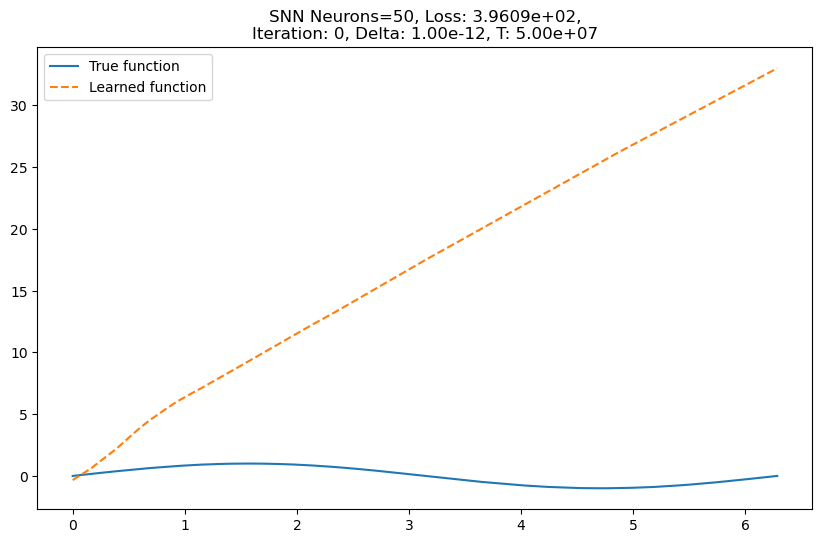

In [5]:
# Prepare the data for animation
fk_hist = loss_history  # Assuming loss_history has the loss at each iteration
deltak_hist = delta_hist  # Assuming delta_hist has delta values at each iteration
tk_hist = tk_hist  # Assuming tk_hist has t values at each iteration
xk_hist = xk_hist  # Assuming xk_hist has the model parameters at each iteration

# Create figure and axis for animation
fig, ax = plt.subplots(figsize=(10, 6))

def plot(k, xk, fk, deltak, tk, ax):
    model.set_parameters(xk)
    ax.clear()  # Clear previous plot to avoid overlap
    ax.plot(x, y_tensor, label='True function')  # Assuming `x` and `y_tensor` are available
    ax.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')  # Assuming model and x_tensor are available
    ax.legend()
    ax.set_title(f"SNN Neurons={n_neurons}, Loss: {fk.item():.4e},\nIteration: {k}, Delta: {deltak:.2e}, T: {tk:.2e}")

# Define the animation update function
def update_plot(frame):
    k = frame
    xk = xk_hist[:,k]
    fk = fk_hist[k]
    deltak = deltak_hist[k]
    tk = tk_hist[k]
    
    plot(k, xk, fk, deltak, tk, ax)

# Ensure the histories have the same length
iterations = len(fk_hist)  # Assuming xk_hist is the longest list and matches the others
print(f'Number of iterations: {iterations}')  # Make sure this is correct

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update_plot, frames=range(iterations), interval=500, repeat=False)

# Save the animation as a GIF (or any format you like)
writer = PillowWriter(fps=50)
ani.save(f'optimization_{n_neurons}.gif', writer=writer)

# Show the plot (optional, depending on whether you want to display it interactively)
plt.show()

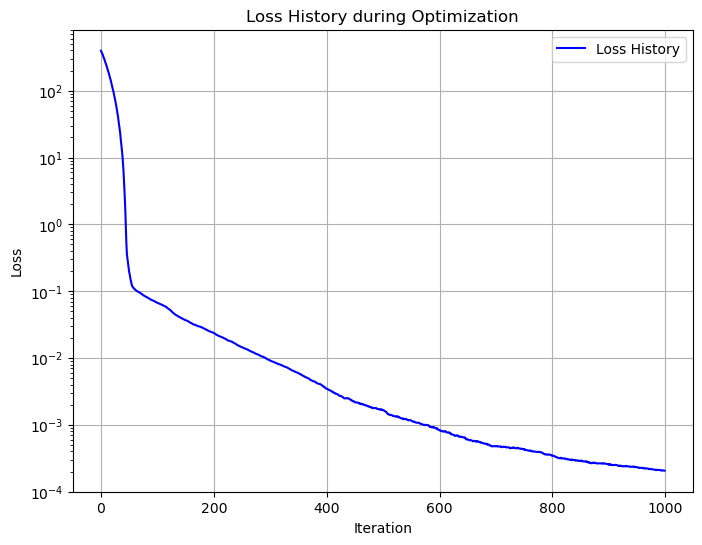

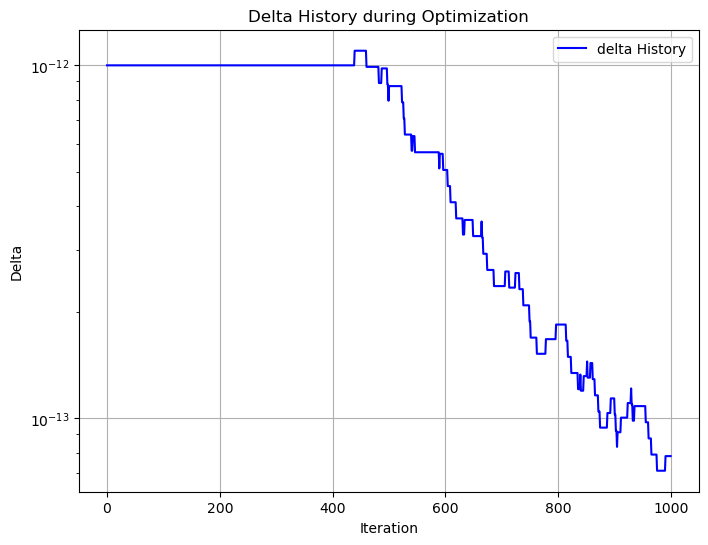

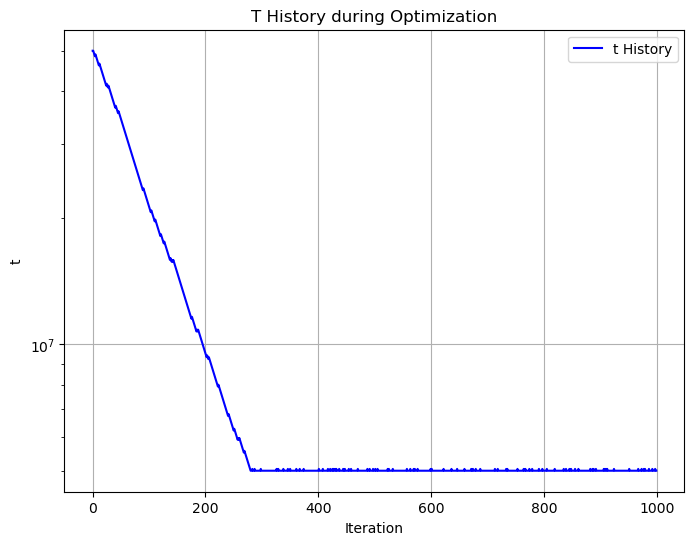

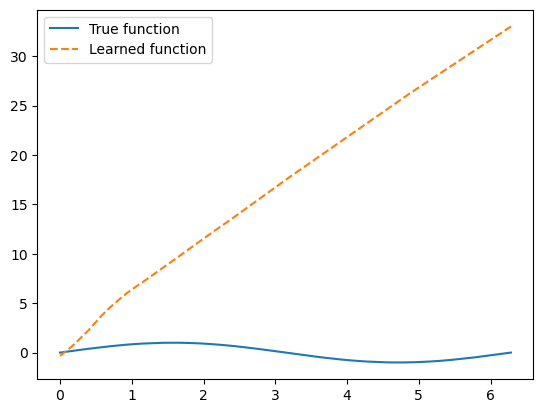

In [6]:
# Visualize the loss history
plt.figure(figsize=(8, 6))
plt.semilogy(loss_history, label='Loss History', color='blue')
plt.title('Loss History during Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the loss history
plt.figure(figsize=(8, 6))
plt.semilogy(delta_hist, label='delta History', color='blue')
plt.title('Delta History during Optimization')
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.semilogy(tk_hist, label='t History', color='blue')
plt.title('T History during Optimization')
plt.xlabel('Iteration')
plt.ylabel('t')
plt.legend()
plt.grid(True)
plt.show()

# Visualise the learned function
plt.figure()
plt.plot(x, y, label='True function')
plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
plt.legend()
plt.show()

In [7]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import torch.nn as nn
# import torch.optim as optim

# from hj_prox_ls import HJ_PROX_LS

# # Hyperparameters
# n_neurons = 50  # Number of neurons in the shallow network
# learning_rate = 0.01
# num_epochs = 1000
# batch_size = 100

# # Generate data
# no_of_samples = 500
# noise_level = 1e-3
# x = np.linspace(0, 2 * np.pi, no_of_samples)
# y = np.sin(x) + noise_level * np.random.randn(*x.shape)  # Add noise to the samples

# # Convert to PyTorch tensors
# x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
# y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# # Create dataset and dataloader
# dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Define the shallow neural network
# class ShallowNet(nn.Module):
#     def __init__(self, n_neurons):
#         super(ShallowNet, self).__init__()
#         self.linear = nn.Linear(1, n_neurons)
#         self.coeffs = nn.Parameter(torch.randn(n_neurons, 1))
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.linear(x)      # Compute w_j * x + b_j
#         x = self.relu(x)        # Apply ReLU activation
#         x = x @ self.coeffs     # Compute sum of c_j * ReLU(...)
#         return x

#     # def set_parameters(self, new_parameters):
#     #     """
#     #     Set model parameters from the flattened parameter vector.
#     #     This method updates the model's parameters from a single flattened tensor.
#     #     """
#     #     offset = 0
#     #     for param in self.parameters():
#     #         param_size = param.numel() 
#     #         new_param_values = new_parameters[offset:offset + param_size]
#     #         new_param_values = new_param_values.view(param.shape)  
#     #         param.data.copy_(new_param_values)  
#     #         offset += param_size  

#     def set_parameters(self, new_parameters):
#         """
#         Set model parameters from the flattened parameter vector.
#         This method updates the model's parameters from a single flattened tensor.

#         Args:
#             new_parameters: A flattened tensor containing all parameters.
#         """
#         offset = 0
#         for param in self.parameters():
#             param_size = param.numel()  # Total number of elements in the parameter
#             # Extract the relevant slice and reshape it to the parameter's original shape
#             if len(new_parameters.shape) == 1:
#                 new_param_values = new_parameters[offset:offset + param_size]
#             else:
#                 new_param_values = new_parameters[0, offset:offset + param_size]  # Access batch dimension
#             new_param_values = new_param_values.view_as(param)  # Match the original shape
#             param.data.copy_(new_param_values)  # Update parameter
#             offset += param_size




# # Initialize model, loss function, and optimizer
# model = ShallowNet(n_neurons)
# criterion = nn.MSELoss()
# # optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # HJ_MAD hyperparameters
# delta0 = 1
# t = 1
# int_samples = int(100)
# delta_dampener=0.8
# beta=0.0
# first_moment = None

# # Use HJ_MAD to optimize the model parameters
# HJ_PROX_LS_alg = HJ_PROX_LS(delta=delta0, t=t, int_samples=int_samples,delta_dampener=delta_dampener,beta=beta,verbose=True)

# # Define the function f (e.g., a loss function based on the model's predictions)
# def Objective_function(x, model, inputs, targets):
#     """
#     Computes the loss based on the given model parameters.

#     Args:
#         x: Tensor of shape (n_samples, n_features) representing flattened parameters.
#         model: The neural network model.
#         inputs: Input batch.
#         targets: Ground truth values.

#     Returns:
#         Tensor of shape (n_samples,) containing the loss for each sample.
#     """
#     n_samples = x.shape[0]
    
#     # Initialize list to store losses
#     sample_losses = []

#     # Compute losses for each sample in the batch
#     for i in range(n_samples):
#         # Extract parameters for the current sample
#         model_params = x[i, :]  # Take the i-th sample
#         model.set_parameters(model_params)  # Update model parameters

#         # Forward pass and loss computation
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         sample_losses.append(loss.item())

#     # Convert the list of losses to a tensor
#     return torch.tensor(sample_losses)


# # Training loop: Iterate through the epochs
# for epoch in range(num_epochs):
#     # Iterate through the dataset in batches
#     for inputs, targets in dataloader:
#         # Define f
#         def f(x):
#             return Objective_function(x, model, inputs, targets)
        
#         # Get the model parameters as a flattened tensor
#         parameters = list(model.parameters())
#         parameter_vector = torch.cat([param.flatten() for param in parameters])
#         parameter_vector = parameter_vector.unsqueeze(0) # shape (1, num_features)

#         # Compute Current Loss
#         loss_old = f(parameter_vector)  # Compute the loss for the current parameters

#         # Run HJ_MAD to optimize the model parameters
#         new_parameters, loss, first_moment = HJ_PROX_LS_alg.run(f, parameter_vector)  # Run HJ_MAD to optimize the model parameters

#         # Update the model parameters with the optimized values
#         model.set_parameters(new_parameters)
        
#     # Print the loss every 100 epochs for monitoring
#     if (epoch + 1) % 100 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Delta: {HJ_PROX_LS_alg.delta}')

# # Visualise the learned function
# plt.figure()
# plt.plot(x, y, label='True function')
# plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
# plt.legend()
# plt.show()

Epoch [100/1000], Loss: 0.0026
Epoch [200/1000], Loss: 0.0028
Epoch [300/1000], Loss: 0.0007
Epoch [400/1000], Loss: 0.0012
Epoch [500/1000], Loss: 0.0093
Epoch [600/1000], Loss: 0.0017
Epoch [700/1000], Loss: 0.0033
Epoch [800/1000], Loss: 0.0007
Epoch [900/1000], Loss: 0.0034
Epoch [1000/1000], Loss: 0.0032


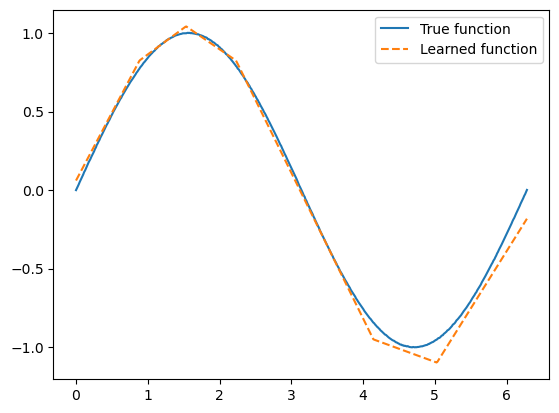

In [8]:

learning_rate = 0.01
num_epochs = 1000
batch_size = 100


# Initialize model, loss function, and optimizer
model = ShallowNet(n_neurons)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
start_time = time.time()
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
elapsed_time = time.time() - start_time
# Visualise the learned function
plt.figure()
plt.plot(x, y, label='True function')
plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
plt.legend()
plt.show()


In [9]:
loss = criterion(model(x_tensor), y_tensor)
print("\n=== Optimization Results ===")
print(f"Elapsed Time        : {elapsed_time:.2f} seconds")
print(f"Final Loss          : {loss.item():.5e}")
print("============================")


=== Optimization Results ===
Elapsed Time        : 53.94 seconds
Final Loss          : 3.25866e-03


In [10]:
# # Define f
# def f(x):
#     return loss_function(x, model, x_tensor, y_tensor)

# def plot(k, xk, fk, deltak, tk, ax):
#     model.set_parameters(xk)
#     ax.clear()  # Clear previous plot to avoid overlap
#     ax.plot(x, y_tensor, label='True function')  # Assuming `x` and `y_tensor` are available
#     ax.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')  # Assuming model and x_tensor are available
#     ax.legend()
#     ax.set_title(f"Iteration: {k}, Loss: {fk.item():.4e},\nDelta: {deltak:.2e}, T: {tk:.2e}")


# model = ShallowNet(n_neurons)

# # HJ_MAD hyperparameters
# delta = 1e-12#5e-11          # Small delta -> Better Approximation of the Moreau Envelope Provided Large T or Close to Global Minimum
# t =   5e+7#5e7            # Large T -> Better Exploration (Moreau Envelope closer to approximate quadratic)
# int_samples = int(500)#500  # Large N -> Better Expectations for Larger T -> Better Exploration (But more expensive)
# max_iters = int(1000)   # Maximum number of iterations
# loss_tol = 9e-5         # Stopping criterion for the loss
# distribution="Cauchy" # Set sampling distribution 

# # Use HJ_MAD to optimize the model parameters
# HJ_MAD_alg = HJ_MD_LS(delta=delta, t=t,distribution=distribution,
#                       int_samples=int_samples, max_iters=max_iters, f_tol=loss_tol,
#                       verbose=True, adaptive_time=True,adaptive_delta=True,
#                       line_search=False, stepsize=1.0)

# # Get the model parameters as a flattened tensor
# parameters = list(model.parameters())
# parameter_vector = torch.cat([param.flatten() for param in parameters])
# parameter_vector = parameter_vector.unsqueeze(0) # shape (1, num_features)

# # Compute Current Loss
# loss_old = f(parameter_vector)  # Compute the loss for the current parameters

# # Run HJ_MAD to optimize the model parameters
# start_time = time.time()
# new_parameters, loss, xk_hist, loss_history, delta_hist, tk_hist, iterations = HJ_MAD_alg.run(f, parameter_vector)  # Run HJ_MAD to optimize the model parameters
# elapsed_time = time.time() - start_time  # Calculate elapsed time

# func_evals = 2*iterations * (int_samples)
# print("\n=== Optimization Results ===")
# print(f"Function Evaluations: {func_evals}")
# print(f"Iterations          : {iterations} (Max: {max_iters})")
# print(f"Elapsed Time        : {elapsed_time:.2f} seconds")
# print(f"Final Loss          : {f(new_parameters).item():.5e}")
# print("============================")

-------------------------- RUNNING HJ-MAD-LS Algorithm ---------------------------
dimension =  150 n_samples =  500
[  0]: fk = 1.36e+02 | deltak = 1.00e-12 | tk = 5.00e+07
    Number of non-zero softmax weights on samples: 1
[  1]: fk = 1.10e+00 | deltak = 1.00e-12 | tk = 5.00e+07
    Number of non-zero softmax weights on samples: 1
[  2]: fk = 1.31e-01 | deltak = 1.00e-12 | tk = 4.95e+07
    Number of non-zero softmax weights on samples: 1
[  3]: fk = 9.02e-02 | deltak = 1.00e-12 | tk = 4.90e+07
    Number of non-zero softmax weights on samples: 1
[  4]: fk = 7.56e-02 | deltak = 1.00e-12 | tk = 4.85e+07
    Number of non-zero softmax weights on samples: 1
[  5]: fk = 6.18e-02 | deltak = 1.00e-12 | tk = 4.90e+07
    Number of non-zero softmax weights on samples: 1
[  6]: fk = 4.76e-02 | deltak = 1.00e-12 | tk = 4.85e+07
    Number of non-zero softmax weights on samples: 1
    f(xk): 4.75668e-02 | f(prox): 4.96593e-02
[  7]: fk = 4.97e-02 | deltak = 9.00e-13 | tk = 4.90e+07
    Number

KeyboardInterrupt: 